### GCA 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

from plot import *
from models import *
from eunn import *

np.random.seed(12)
tf.set_random_seed(12)

### We first set the parameters and generate a dataset of dependent Gaussian mixtures.

In [2]:
### Define the data parameters
n = 10000 # Number of data samples
p = 4
m = 10 # Number of noise added points per data sample
sigma_xi = 0.25 # Standard deviation of Gaussian noise
mu = np.zeros(p)
sigma_s_sq = 1.0
dep_level = 0.3
a = 0.5 # f(x) = x^a in nonparanormal model

# Create dependence in this way
Omega_1 = np.diag(np.repeat(sigma_s_sq, 4))
Omega_1[np.where(Omega_1 == 0)] = dep_level
Omega_1[1, 3] = 0
Omega_1[3, 1] = 0
Omega_1[2, 3] = 0
Omega_1[3, 2] = 0

from scipy.linalg import block_diag
#Omega = block_diag(Omega_1, Omega_1, Omega_1, Omega_1)
Omega = Omega_1
Sigma = np.linalg.inv(Omega)
print(Omega)
print("\n")
print(Sigma)
print("\n")

# Define the model parameters
d0 = p
l = 2
l_nodes = l
l_pairs = l 
nl = 1
nl_nodes = nl
nl_pairs = nl

# Create W_true
#M = np.random.normal(0, 2, p**2).reshape(p, p)
#W_true, D, V = np.linalg.svd(M)

# Or read in a W_true that we know is in parameter space of eunn code
W_true = np.genfromtxt('W_p4_0.csv', delimiter=',')

# Print W_true and check that it is orthogonal
#print(np.matrix.round(W_true, 2))
#print("\n")
#print(np.matrix.round(np.matmul(W_true, W_true.transpose()), 2))
#print("\n")
#print(np.matrix.round(np.matmul(W_true.transpose(), W_true), 2))

[[1.  0.3 0.3 0.3]
 [0.3 1.  0.3 0. ]
 [0.3 0.3 1.  0. ]
 [0.3 0.  0.  1. ]]


[[ 1.29611167 -0.29910269 -0.29910269 -0.3888335 ]
 [-0.29910269  1.1679248  -0.26064663  0.08973081]
 [-0.29910269 -0.26064663  1.1679248   0.08973081]
 [-0.3888335   0.08973081  0.08973081  1.11665005]]




### Show the original source data, which is what we hope to recover after we have mixed it using A.

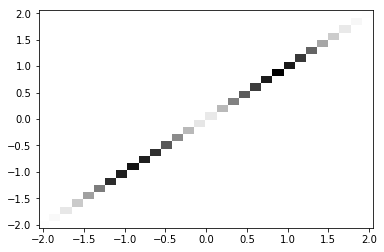

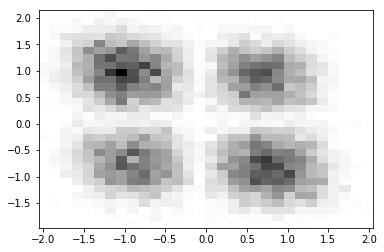

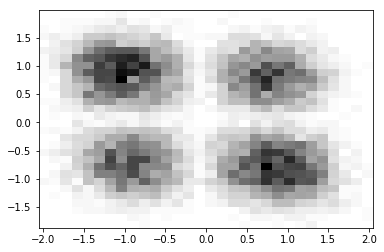

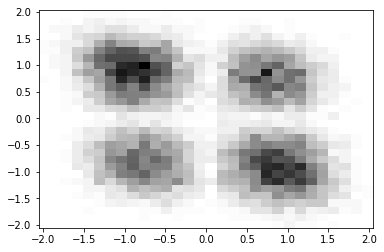

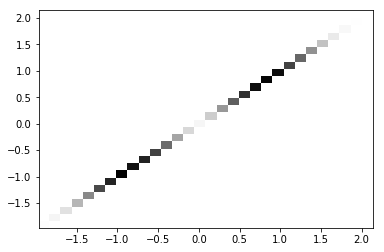

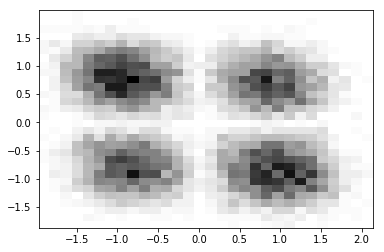

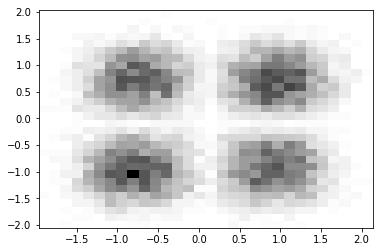

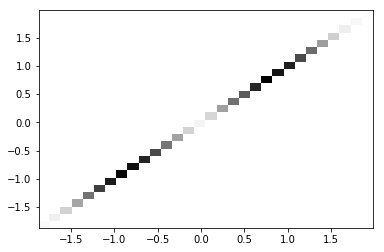

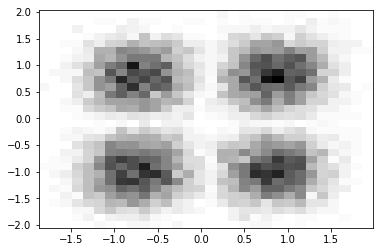

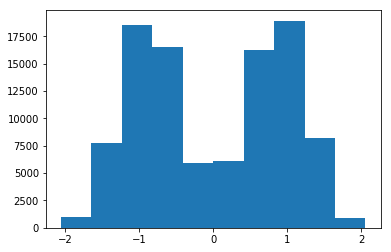

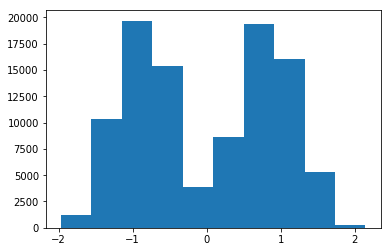

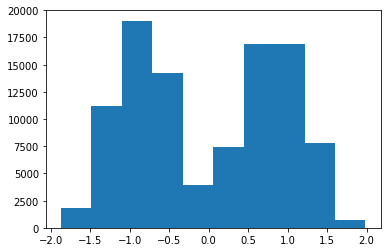

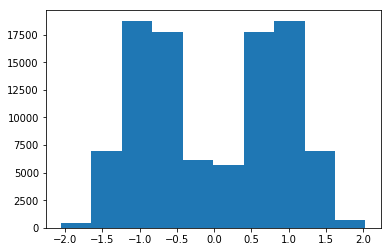

In [3]:
# Create source data
s_x = np.zeros((n*m, p))
s_xi = np.zeros((n*m, p))

for i in range(n):
    s_x[m*i:m*i+m, ] = np.random.multivariate_normal(mu, Sigma, 1)
for i in range(n*m):
    for j in range(p):
        s_x[i, j] = np.sign(s_x[i, j]) * np.abs(s_x[i, j])**a
for i in range(n):
    s_xi[m*i:m*i+m] = s_x[m*i:m*i+m] + np.random.normal(0., sigma_xi, m*p).reshape((m, p))
    
x_observed = np.matmul(s_x, W_true.transpose())
xi_observed = np.matmul(s_xi, W_true.transpose())

# OR more correctly,
#xi_observed = np.zeros((n*m, p))
#for i in range(n):
#    xi_observed[m*i:m*i+m] = x_observed[m*i:m*i+m] + np.random.normal(0., sigma_xi, m*p).reshape((m, p))
  

# Plot the original source s
plot_bvt(s_x)
plot_unvt(s_x)
# Plot the transformed data
#plot_bvt(x_observed)
#plot_unvt(x_observed)

### We will use the model $\log p(s) \propto \sum_{i=1}^p f_i(s_i) + \sum_{i \ne j} f_{i,j}(s_i, s_j)$. Recall $s = Wx$.

In [4]:
tf.reset_default_graph()

nodes_block = MLPBlock(input_dim=d0, hidden_dim=l_nodes, n_layers=nl_nodes, stddev=1.0) # MLP for each coordinate to enforce indep
pairs_block = MLPPairs_1(input_dim=d0, hidden_dim=l_pairs, n_layers=nl_pairs, stddev=1.0)

# Define network in xi
x = tf.placeholder(tf.float32, shape=[None, d0])
xi = tf.placeholder(tf.float32, shape=[None, d0])
h_xi = eunn_feedforward(xi)

nodes = nodes_block(h_xi, activation=tf.nn.tanh)
pairs = pairs_block(h_xi, activation=tf.nn.tanh)

# OR just a general MLP
#dep_block = MLP([d0, l, l, l, 1], [tf.nn.tanh, tf.nn.tanh, tf.nn.tanh, None], 1.0)
#y_xi = tf.math.reduce_sum(dep_block(h_xi), axis = 1)

# OR nodes plus pairs  
y_xi = tf.math.reduce_sum(nodes, axis=1) + tf.math.reduce_sum(pairs, axis=1)

# OR just do nodes + a general MLP
#dep_block = MLP([d0, l, l, l, 1], [tf.nn.tanh, tf.nn.tanh, tf.nn.tanh, None], 1.0)
#y_xi = tf.math.reduce_sum(nodes, axis=1) + tf.math.reduce_sum(dep_block(h_xi), axis = 1)

# OR looping over adding each pairwise function
#y_xi = tf.math.reduce_sum(nodes, axis=1)

# OR
#for u in range(p):
#    node_block = MLP([1, l_pairs, l_pairs, l_pairs, 1], [tf.nn.tanh, tf.nn.tanh, tf.nn.tanh, None], 1.0)
#    y_xi += tf.math.reduce_sum(node_block(tf.gather(h_xi, [u], axis = 1)), axis = 1)

#for u in range(p):
#    for v in range(u+1, p):
 #       dep_block = MLP([2, l_pairs, l_pairs, l_pairs, 1], [tf.nn.tanh, tf.nn.tanh, tf.nn.tanh, None], 1.0)
#        y_xi += tf.math.reduce_sum(dep_block(tf.gather(h_xi, [u, v], axis = 1)), axis = 1)


W0224 17:44:53.782951 140735988163456 deprecation_wrapper.py:119] From /Users/nataliedoss/venv/models.py:65: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0224 17:44:53.823771 140735988163456 deprecation_wrapper.py:119] From /Users/nataliedoss/venv/eunn.py:51: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.



In [ ]:
### Define the loss
grad_by_xi = tf.gradients(y_xi, xi)[0]
loss = tf.square(tf.norm(x - xi + sigma_xi**2 * grad_by_xi)) + 2.0 * tf.norm(y_xi)

In [ ]:
# Another way for p = 4
#tf.reset_default_graph()

# ind_block = MLPBlock(input_dim=d0, hidden_dim=l, n_layers=nl, stddev=1.0) # MLP for each coordinate to enforce indep
# dep_block = MLP([d0, l, l, l, 1], [tf.nn.tanh, tf.nn.tanh, tf.nn.tanh, None], 1.0) # MLP for dependence

# dep_block_1 = MLP([2, l, l, l, 1], [tf.nn.tanh, tf.nn.tanh, tf.nn.tanh, None], 1.0)
# dep_block_2 = MLP([2, l, l, l, 1], [tf.nn.tanh, tf.nn.tanh, tf.nn.tanh, None], 1.0)
# dep_block_3 = MLP([2, l, l, l, 1], [tf.nn.tanh, tf.nn.tanh, tf.nn.tanh, None], 1.0)
# dep_block_4 = MLP([2, l, l, l, 1], [tf.nn.tanh, tf.nn.tanh, tf.nn.tanh, None], 1.0)
# dep_block_5 = MLP([2, l, l, l, 1], [tf.nn.tanh, tf.nn.tanh, tf.nn.tanh, None], 1.0)
# dep_block_6 = MLP([2, l, l, l, 1], [tf.nn.tanh, tf.nn.tanh, tf.nn.tanh, None], 1.0)

# # Define network in xi
# x = tf.placeholder(tf.float32, shape=[None, d0])
# xi = tf.placeholder(tf.float32, shape=[None, d0])
# h_xi = eunn_feedforward(xi)
# ind_term = ind_block(h_xi, activation=tf.nn.tanh)
# #dep_term = dep_block(h_xi)

# dep_term_1 = dep_block_1(tf.gather(h_xi, [0, 1], axis = 1))
# dep_term_2 = dep_block_2(tf.gather(h_xi, [0, 2], axis = 1))
# dep_term_3 = dep_block_3(tf.gather(h_xi, [0, 3], axis = 1))
# dep_term_4 = dep_block_4(tf.gather(h_xi, [1, 2], axis = 1))
# dep_term_5 = dep_block_5(tf.gather(h_xi, [1, 3], axis = 1))
# dep_term_6 = dep_block_6(tf.gather(h_xi, [2, 3], axis = 1))

# # Final function 
# y_xi = tf.math.reduce_sum(ind_term, axis=1) \
# + tf.math.reduce_sum(dep_term_1, axis = 1) \
# + tf.math.reduce_sum(dep_term_2, axis = 1) \
# + tf.math.reduce_sum(dep_term_3, axis = 1) \
# + tf.math.reduce_sum(dep_term_4, axis = 1) \
# + tf.math.reduce_sum(dep_term_5, axis = 1) \
# + tf.math.reduce_sum(dep_term_6, axis = 1)

# Add penalty to loss in same way..

### Train the model

In [ ]:
nepoch = 1200
lr = 0.005
train_step = tf.train.AdamOptimizer(lr).minimize(loss)
train_loss = []
t0 = time.time()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for t in range(nepoch):
        _, loss_at_t = sess.run([train_step, loss], feed_dict={x: x_observed, xi: xi_observed})
        train_loss.append(loss_at_t)
        
        # Display logs per epoch step
        if t % 20 == 0:
            print("Epoch:", '%04d' % (t+1), "cost=", "{:.9f}".format(loss_at_t))

    # Save the trained parameters
    saver = tf.train.Saver()
    saver.save(sess, 'my_test_model', global_step=nepoch)
    
t1 = time.time()

# Plot of loss vs. number of epochs
plt.plot(np.arange(nepoch), train_loss)

W0224 17:44:54.230443 140735988163456 deprecation.py:323] From /Users/nataliedoss/venv/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:318: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch: 0001 cost= 29922.169921875
Epoch: 0021 cost= 27031.699218750
Epoch: 0041 cost= 25542.751953125
Epoch: 0061 cost= 24941.605468750
Epoch: 0081 cost= 24725.878906250
Epoch: 0101 cost= 24638.609375000
Epoch: 0121 cost= 24571.060546875
Epoch: 0141 cost= 24508.054687500
Epoch: 0161 cost= 24445.462890625
Epoch: 0181 cost= 24382.537109375
Epoch: 0201 cost= 24318.302734375
Epoch: 0221 cost= 24251.615234375
Epoch: 0241 cost= 24181.826171875
Epoch: 0261 cost= 24109.240234375
Epoch: 0281 cost= 24033.986328125
Epoch: 0301 cost= 23952.578125000
Epoch: 0321 cost= 23856.355468750
Epoch: 0341 cost= 23744.125000000
Epoch: 0361 cost= 23619.322265625
Epoch: 0381 cost= 23485.187500000
Epoch: 0401 cost= 23336.480468750
Epoch: 0421 cost= 23165.914062500


In [ ]:
# Measure time to train
print(t1-t0) 

### Print the estimated W and compare it to the truth. Remember they should be comparable up to permutation of columns.

In [ ]:
# Find the W estimate using x = e_j to obtain columns
cols = np.identity(p)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('my_test_model-{}.meta'.format(nepoch))
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    W_est = sess.run(h_xi, feed_dict = {xi: cols})

print("The estimated W is: ")
print(np.matrix.round(W_est, 2))
print("\n")
print ("The true W is: ")
print(np.matrix.round(W_true, 2))
print("\n")
# Test orthogonality
#print(np.matrix.round(np.matmul(W_est, W_est.transpose()), 2))
#print("\n")
#print(np.matrix.round(np.matmul(W_est.transpose(), W_est), 2))

# Save this W_est
np.savetxt("W.csv", W_est, delimiter=",")

### Generate some test data.

In [ ]:
test_size = 20000
s_test = np.zeros((test_size, p))
for i in range(test_size):
    s_test[i, ] = np.random.multivariate_normal(mu, Sigma, 1)

for i in range(test_size):
    for j in range(p):
        s_test[i, j] = np.sign(s_test[i, j]) * np.abs(s_test[i, j])**0.5

x_test = np.matmul(s_test, W_true.transpose())

# Compare our newly generated data to the original used to train
#plot_bvt(x_test)
#plot_bvt(x_observed)



### Compare $\hat W x$ to the original source s. We plot the bivariate distributions to see if we captured the dependence and the univariate histograms to see if we captured the marginals. We were pretty successful. The x is the above test data generated according to the model.

In [ ]:
# Get h = hat W x
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('my_test_model-{}.meta'.format(nepoch))
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    h_test = sess.run(h_xi, feed_dict = {xi: x_test})

# Plot the pairs
plot_bvt(h_test)
plot_unvt(h_test)

# Or get h = hat W x another way:
#h_test_again = np.matmul(x_test, W_est)
#plot_bvt(h_test_again)
#plot_unvt(h_test_again)

In [ ]:
# Examine the estimates of density coefficients (weights and biases)
#with tf.Session() as sess:    
#    saver = tf.train.import_meta_graph('my_test_model-{}.meta'.format(nepoch))
#    saver.restore(sess,tf.train.latest_checkpoint('./'))
#    vars = tf.trainable_variables()
    #print(vars) #some info about variables...
#    vars_vals = sess.run(vars)
#    for var, val in zip(vars, vars_vals):
#        print("var: {}, value: {}".format(var.name, val)) 



### Compare to ICA on same training data

In [ ]:
# Run on x_observed. Look at the estimated source.
#from sklearn.decomposition import FastICA
#transformer = FastICA(n_components = p, random_state=0)
#X_transformed = transformer.fit_transform(x_test)

# Or do on test data?
#plot_bvt(X_transformed)
#plot_unvt(X_transformed)

### Show a single bivariate density estimate.

In [ ]:
npoints = 200
amin = -4.; amax = 4.
space = (amax-amin)/npoints

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('my_test_model-{}.meta'.format(nepoch))
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    ys = np.zeros((npoints, npoints))
    ps = np.zeros((npoints, npoints))
    for i in range(npoints):
        for j in range(npoints):
            h_in = np.array([(amin+space*i, amin+space*j, -1, -1)])
            y_out = sess.run(y_xi, feed_dict = {h_xi: h_in})
            ys[i, j] = y_out[0]
            ps[i, j] = np.exp(-y_out[0])

            
seq = np.linspace(amin, amax, npoints, endpoint=False)
X, Y = np.meshgrid(seq, seq)

# Unnormalized density (computed from the trained model)
plt.pcolormesh(X, Y, -ps, cmap='gray')


### Show a single univariate density estimate.

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('my_test_model-{}.meta'.format(nepoch))
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    xs = []
    ys = []
    ps = []
    for i in range(6000):
        h_in = np.array([[-3 + 0.001*i, -1, -1, -1]])
        y_out = sess.run(y_xi, feed_dict = {h_xi: h_in}).reshape(-1)
        xs.append(-3 + 0.001*i)
        ys.append(y_out)
        ps.append(np.exp(-y_out))


# Energy (according to the trained model)
plt.plot(xs, ps)